In [4]:
from keras.applications import InceptionV3
import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import numpy as np
import os

import matplotlib.pyplot as plt

# 1. Define Input Parameters

In [15]:
# mobileNet was designed to work on 224X224 input image
img_rows, img_cols = (299, 299)

# define number of classes in data
num_classes = 17

# define batch size
batch_size = 32

# 2. Load Data

In [16]:
train_images_dir = '17_flowers/train'
test_images_dir = '17_flowers/validation'

# Define image data generators
# perform image augmentation to save model from overfitting the training data
# augmentation will create various batches of images & will apply various transformations on images like flipping
# hence providing the overall more training data without adding anymore images
# shear_range & zoom_range are to define how much randomization we want to apply on data
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=keras.applications.inception_v3.preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input)

# target size: same as input shape in classifier as this will be the input to classifier
# batch_size: number of inputs after which weights will be updated
# class_mode: ['binary', 'categorical']
training_set = train_datagen.flow_from_directory(train_images_dir,
                                                target_size = (img_rows, img_cols),
                                                batch_size = batch_size,
                                                class_mode = 'categorical',
                                                seed=67)

test_set = test_datagen.flow_from_directory(test_images_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


# 3. Setup the Model

In [17]:
# 1. load the mobileNet model without the top layer so that we can add custom layers in the end as per our data
inception_v3 = InceptionV3(weights='imagenet',
                    include_top=False,
                    input_shape = (img_rows, img_cols, 3))
inception_v3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [21]:
# 2. freeze the layers of model other than BN
for layer in inception_v3.layers:
    if layer.__class__.__name__!='BatchNormalization':
        layer.trainable = False
    
# print the layer names
for i, layer in enumerate(inception_v3.layers):
    print(str(i)+" "+layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization True
3 Activation False
4 Conv2D False
5 BatchNormalization True
6 Activation False
7 Conv2D False
8 BatchNormalization True
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization True
13 Activation False
14 Conv2D False
15 BatchNormalization True
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization True
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization True
24 BatchNormalization True
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization True
33 BatchNormalization True
34 BatchNormalization True
35 BatchNormalization True
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization True
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization True
47 BatchNormalization

In [22]:
# 3. Add custom layers as per data
x = inception_v3.output
pool1 = GlobalAveragePooling2D()(x)
dense1 = Dense(num_classes, activation='softmax')(pool1)

model = Model(inputs=inception_v3.inputs, output=dense1)
model.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


# 4. Define other model parameters

In [23]:
checkpoint = ModelCheckpoint('flower17.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1
                            )

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.2,
                              min_delta=0.0001,
                              patience=3,
                              verbose=1)

# 5. Fitting the model

In [24]:
history = model.fit_generator(training_set,
                              steps_per_epoch = 1190//batch_size,
                              epochs = 25,
                              validation_data = test_set,
                              validation_steps = 170//batch_size,
                              callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/25
37/37 [==============================] - 62s 2s/step - loss: 2.3580 - acc: 0.3066 - val_loss: 1.7113 - val_acc: 0.5687

Epoch 00001: val_loss improved from inf to 1.71131, saving model to flower17.h5
Epoch 2/25
37/37 [==============================] - 38s 1s/step - loss: 1.4206 - acc: 0.6614 - val_loss: 1.1448 - val_acc: 0.7754

Epoch 00002: val_loss improved from 1.71131 to 1.14477, saving model to flower17.h5
Epoch 3/25
37/37 [==============================] - 41s 1s/step - loss: 0.9475 - acc: 0.8038 - val_loss: 0.7266 - val_acc: 0.8261

Epoch 00003: val_loss improved from 1.14477 to 0.72661, saving model to flower17.h5
Epoch 4/25
37/37 [==============================] - 41s 1s/step - loss: 0.7203 - acc: 0.8685 - val_loss: 0.4993 - val_acc: 0.9130

Epoch 00004: val_loss improved from 0.72661 to 0.49931, saving model to flower17.h5
Epoch 5/25
37/37 [==============================] - 42s 1s/step - loss: 0.5551 - acc: 0.8857 - val_loss: 0.4741 - val_acc: 0.9130

Epoch 00005: 

# 6. Predictions

Predicted Class: bluebell
Actual Class: bluebell


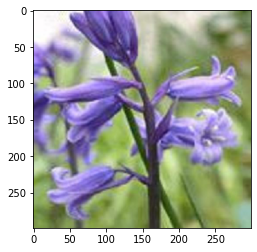

Predicted Class: colts_foot
Actual Class: colts_foot


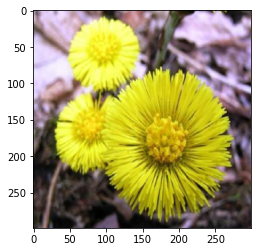

Predicted Class: buttercup
Actual Class: buttercup


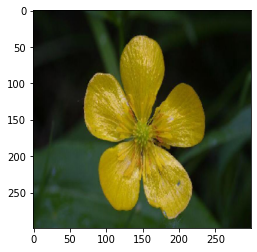

Predicted Class: daisy
Actual Class: daisy


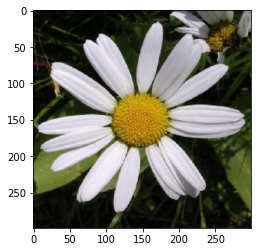

Predicted Class: snowdrop
Actual Class: snowdrop


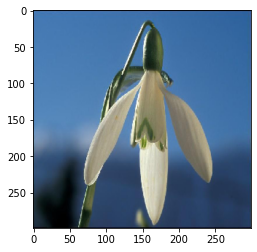

Predicted Class: crocus
Actual Class: crocus


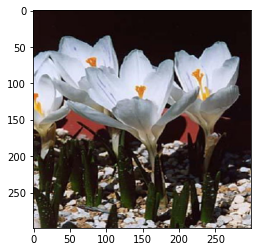

Predicted Class: buttercup
Actual Class: cowslip


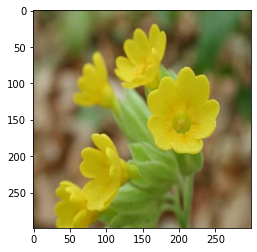

Predicted Class: dandelion
Actual Class: dandelion


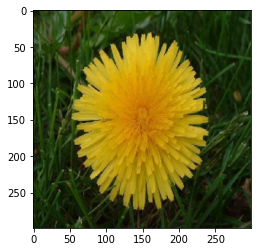

Predicted Class: snowdrop
Actual Class: lily_valley


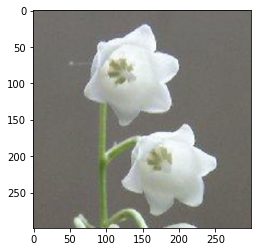

Predicted Class: iris
Actual Class: iris


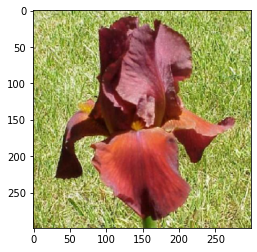

Predicted Class: fritillary
Actual Class: fritillary


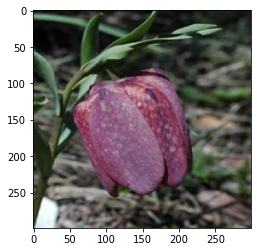

Predicted Class: daffodil
Actual Class: daffodil


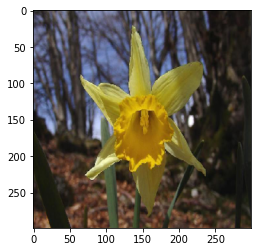

Predicted Class: pansy
Actual Class: pansy


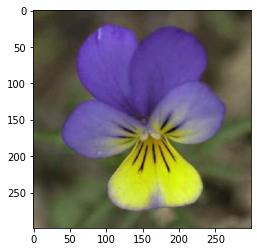

Predicted Class: windflower
Actual Class: windflower


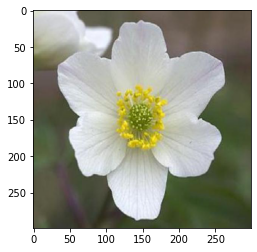

Predicted Class: tigerlily
Actual Class: tigerlily


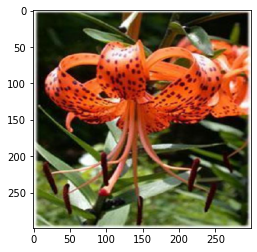

Predicted Class: tulip
Actual Class: tulip


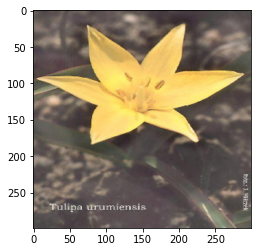

Predicted Class: sunflower
Actual Class: sunflower


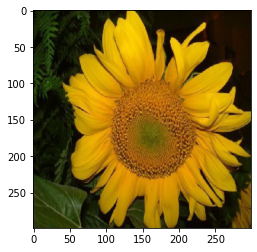

In [29]:
# get all classes folder names
image_folders = os.listdir(test_images_dir)
for i in range(17):
    # choose one random folder (0, 16)
    folder_index = i

    # get all images in the specified folder
    val_images = os.listdir(os.path.join(test_images_dir, image_folders[folder_index]))
    index = 9

    # load image
    test_image = image.load_img(os.path.join(test_images_dir, image_folders[folder_index]+'/'+val_images[index]), target_size=(img_cols, img_rows))
    plt.imshow(test_image, interpolation='bilinear')
    # convert into array
    # dimension = 299, 299, 3
    test_image = image.img_to_array(test_image)
    # add batch size as 4th dimension
    test_image = np.expand_dims(test_image, axis = 0)
    # preprocess image as per resnet model
    test_image = keras.applications.inception_v3.preprocess_input(test_image)
    # predict on rescaled image
    result = model.predict(test_image)

    # get class indices
    class_labels = {v:k for k,v in training_set.class_indices.items()}

    # get class attributes
    print('Predicted Class:', class_labels[np.argmax(result)])
    print('Actual Class:', image_folders[folder_index])
    plt.show()